# SOM Cross-Mapping Analysis: 2x2 to 5x4

By: Ty Janoski

This notebook traces how flash flood events classified by the 2x2 SOM (trained on FFE-only data) 
map to the 5x4 SOM (trained on all daily data). This helps understand how the synoptic patterns
identified by each SOM relate to each other.

## Setup

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots  # noqa: F401
from matplotlib.colors import to_rgba
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch
import matplotlib.patheffects as patheffects


plt.style.use(["science", "nature", "grid"])
plt.rcParams["text.usetex"] = True


## Load BMU Data from Both SOMs

The 2x2 SOM was trained on flash flood events only (hourly data, 117 events), while the 5x4 SOM
was trained on all daily data (115 unique flash flood days). The difference arises because 2 days
have multiple flash flood events with unique episode IDs.

We match events by date to see how each 2x2 node's events distribute across the 5x4 SOM. Events
occurring on the same day will share the same 5x4 SOM assignment.

In [7]:
# Load BMU assignments from both SOMs
bmu_2x2 = pd.read_csv("data/som_2x2_bmus.csv", parse_dates=["timestamp"])
bmu_5x4 = pd.read_csv("data/som_5x4_ffe_bmus.csv", parse_dates=["timestamp"])

print(f"2x2 SOM: {len(bmu_2x2)} events")
print(f"5x4 SOM: {len(bmu_5x4)} flash flood days")

2x2 SOM: 117 events
5x4 SOM: 115 flash flood days


In [8]:
# Normalize timestamps to date for matching
# The 2x2 SOM uses event times (may have multiple per day)
# The 5x4 SOM uses daily data
bmu_2x2["date"] = bmu_2x2["timestamp"].dt.normalize()
bmu_5x4["date"] = bmu_5x4["timestamp"].dt.normalize()

# Rename columns to distinguish between the two SOMs
bmu_2x2 = bmu_2x2.rename(columns={"node_i": "node_2x2_i", "node_j": "node_2x2_j"})
bmu_5x4 = bmu_5x4.rename(columns={"node_i": "node_5x4_i", "node_j": "node_5x4_j"})

# Merge on date
merged = bmu_2x2.merge(bmu_5x4[["date", "node_5x4_i", "node_5x4_j"]], on="date", how="inner")

print(f"Matched {len(merged)} events between the two SOMs")
merged.head()

Matched 117 events between the two SOMs


,timestamp,node_2x2_i,node_2x2_j,date,node_5x4_i,node_5x4_j
0,1996-07-03 19:00:00,0,1,1996-07-03,4,0
1,1996-07-08 22:00:00,0,1,1996-07-08,4,1
2,1996-07-13 12:00:00,0,1,1996-07-13,4,3
3,1996-07-31 14:00:00,0,0,1996-07-31,4,3
4,1996-09-08 19:00:00,1,1,1996-09-08,4,3


In [9]:
# Identify days with multiple events
multi_event_days = bmu_2x2.groupby("date").size()
multi_event_days = multi_event_days[multi_event_days > 1]

print(f"Unique flash flood days in 2x2 SOM: {bmu_2x2['date'].nunique()}")
print(f"Days with multiple events: {len(multi_event_days)}")
print("\nMulti-event days:")
for date, count in multi_event_days.items():
    day_events = bmu_2x2[bmu_2x2["date"] == date]
    nodes = day_events.apply(
        lambda r: f"({int(r['node_2x2_i'])},{int(r['node_2x2_j'])})", axis=1
    ).tolist()
    print(f"  {date.strftime('%Y-%m-%d')}: {count} events -> 2x2 nodes {nodes}")


Unique flash flood days in 2x2 SOM: 115
Days with multiple events: 2

Multi-event days:
  2000-08-28: 2 events -> 2x2 nodes ['(1,1)', '(1,1)']
  2021-08-22: 2 events -> 2x2 nodes ['(1,0)', '(1,0)']


In [11]:
# Show multi-event days with their 5x4 SOM mapping
print("Multi-event days with 2x2 -> 5x4 mapping:")
for date in multi_event_days.index:
    day_merged = merged[merged["date"] == date]
    # Use numeric columns (string labels aren't created yet)
    node_5x4 = f"({int(day_merged['node_5x4_i'].iloc[0])},{int(day_merged['node_5x4_j'].iloc[0])})"
    nodes_2x2 = [f"({int(r['node_2x2_i'])},{int(r['node_2x2_j'])})" for _, r in day_merged.iterrows()]
    same_node = len(set(nodes_2x2)) == 1
    status = "(same 2x2 node)" if same_node else "(DIFFERENT 2x2 nodes)"
    print(f"  {date.strftime('%Y-%m-%d')}: 2x2 {nodes_2x2} -> 5x4 {node_5x4} {status}")

print(f"\nNote: All {len(merged)} events (including multi-event days) are counted in the analysis.")

Multi-event days with 2x2 -> 5x4 mapping:
  2000-08-28: 2x2 ['(1,1)', '(1,1)'] -> 5x4 (1,0) (same 2x2 node)
  2021-08-22: 2x2 ['(1,0)', '(1,0)'] -> 5x4 (0,1) (same 2x2 node)

Note: All 117 events (including multi-event days) are counted in the analysis.


In [12]:
# Create combined node labels for easier analysis
merged["node_2x2"] = merged.apply(lambda r: f"({int(r['node_2x2_i'])},{int(r['node_2x2_j'])})", axis=1)
merged["node_5x4"] = merged.apply(lambda r: f"({int(r['node_5x4_i'])},{int(r['node_5x4_j'])})", axis=1)

## Cross-Tabulation: 2x2 Node to 5x4 Node Mapping

In [13]:
# Create cross-tabulation
crosstab = pd.crosstab(merged["node_2x2"], merged["node_5x4"])
print("Cross-tabulation of 2x2 SOM nodes to 5x4 SOM nodes:")
crosstab

Cross-tabulation of 2x2 SOM nodes to 5x4 SOM nodes:


node_5x4,"(0,0)","(0,1)","(0,2)","(0,3)","(1,0)","(1,1)","(1,2)","(1,3)","(2,0)","(2,1)","(2,2)","(2,3)","(3,0)","(3,1)","(3,2)","(3,3)","(4,0)","(4,1)","(4,2)","(4,3)"
node_2x2,,,,,,,,,,,,,,,,,,,,
"(0,0)",0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,7,0,0,0,13
"(0,1)",0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,1,7,5,6,14
"(1,0)",2,3,3,8,0,1,4,8,0,0,2,3,0,0,0,0,0,0,0,0
"(1,1)",3,0,0,0,5,0,0,0,2,3,2,0,1,1,1,2,2,0,0,1


In [14]:
# Compute mapping statistics per 2x2 node
print("\nMapping Summary by 2x2 SOM Node:")
print("=" * 60)

for node_2x2 in sorted(merged["node_2x2"].unique()):
    subset = merged[merged["node_2x2"] == node_2x2]
    n_events = len(subset)
    
    # Count distribution across 5x4 nodes
    dist = subset["node_5x4"].value_counts()
    
    print(f"\n2x2 Node {node_2x2} ({n_events} events):")
    for node_5x4, count in dist.items():
        pct = 100 * count / n_events
        print(f"  -> 5x4 Node {node_5x4}: {count} ({pct:.1f}%)")


Mapping Summary by 2x2 SOM Node:

2x2 Node (0,0) (23 events):
  -> 5x4 Node (4,3): 13 (56.5%)
  -> 5x4 Node (3,3): 7 (30.4%)
  -> 5x4 Node (2,3): 3 (13.0%)

2x2 Node (0,1) (37 events):
  -> 5x4 Node (4,3): 14 (37.8%)
  -> 5x4 Node (4,0): 7 (18.9%)
  -> 5x4 Node (4,2): 6 (16.2%)
  -> 5x4 Node (4,1): 5 (13.5%)
  -> 5x4 Node (3,0): 2 (5.4%)
  -> 5x4 Node (3,2): 2 (5.4%)
  -> 5x4 Node (3,3): 1 (2.7%)

2x2 Node (1,0) (34 events):
  -> 5x4 Node (1,3): 8 (23.5%)
  -> 5x4 Node (0,3): 8 (23.5%)
  -> 5x4 Node (1,2): 4 (11.8%)
  -> 5x4 Node (0,2): 3 (8.8%)
  -> 5x4 Node (2,3): 3 (8.8%)
  -> 5x4 Node (0,1): 3 (8.8%)
  -> 5x4 Node (0,0): 2 (5.9%)
  -> 5x4 Node (2,2): 2 (5.9%)
  -> 5x4 Node (1,1): 1 (2.9%)

2x2 Node (1,1) (23 events):
  -> 5x4 Node (1,0): 5 (21.7%)
  -> 5x4 Node (2,1): 3 (13.0%)
  -> 5x4 Node (0,0): 3 (13.0%)
  -> 5x4 Node (4,0): 2 (8.7%)
  -> 5x4 Node (2,0): 2 (8.7%)
  -> 5x4 Node (2,2): 2 (8.7%)
  -> 5x4 Node (3,3): 2 (8.7%)
  -> 5x4 Node (4,3): 1 (4.3%)
  -> 5x4 Node (3,0): 1 (4

## Visualization: Heatmap of Node Mapping

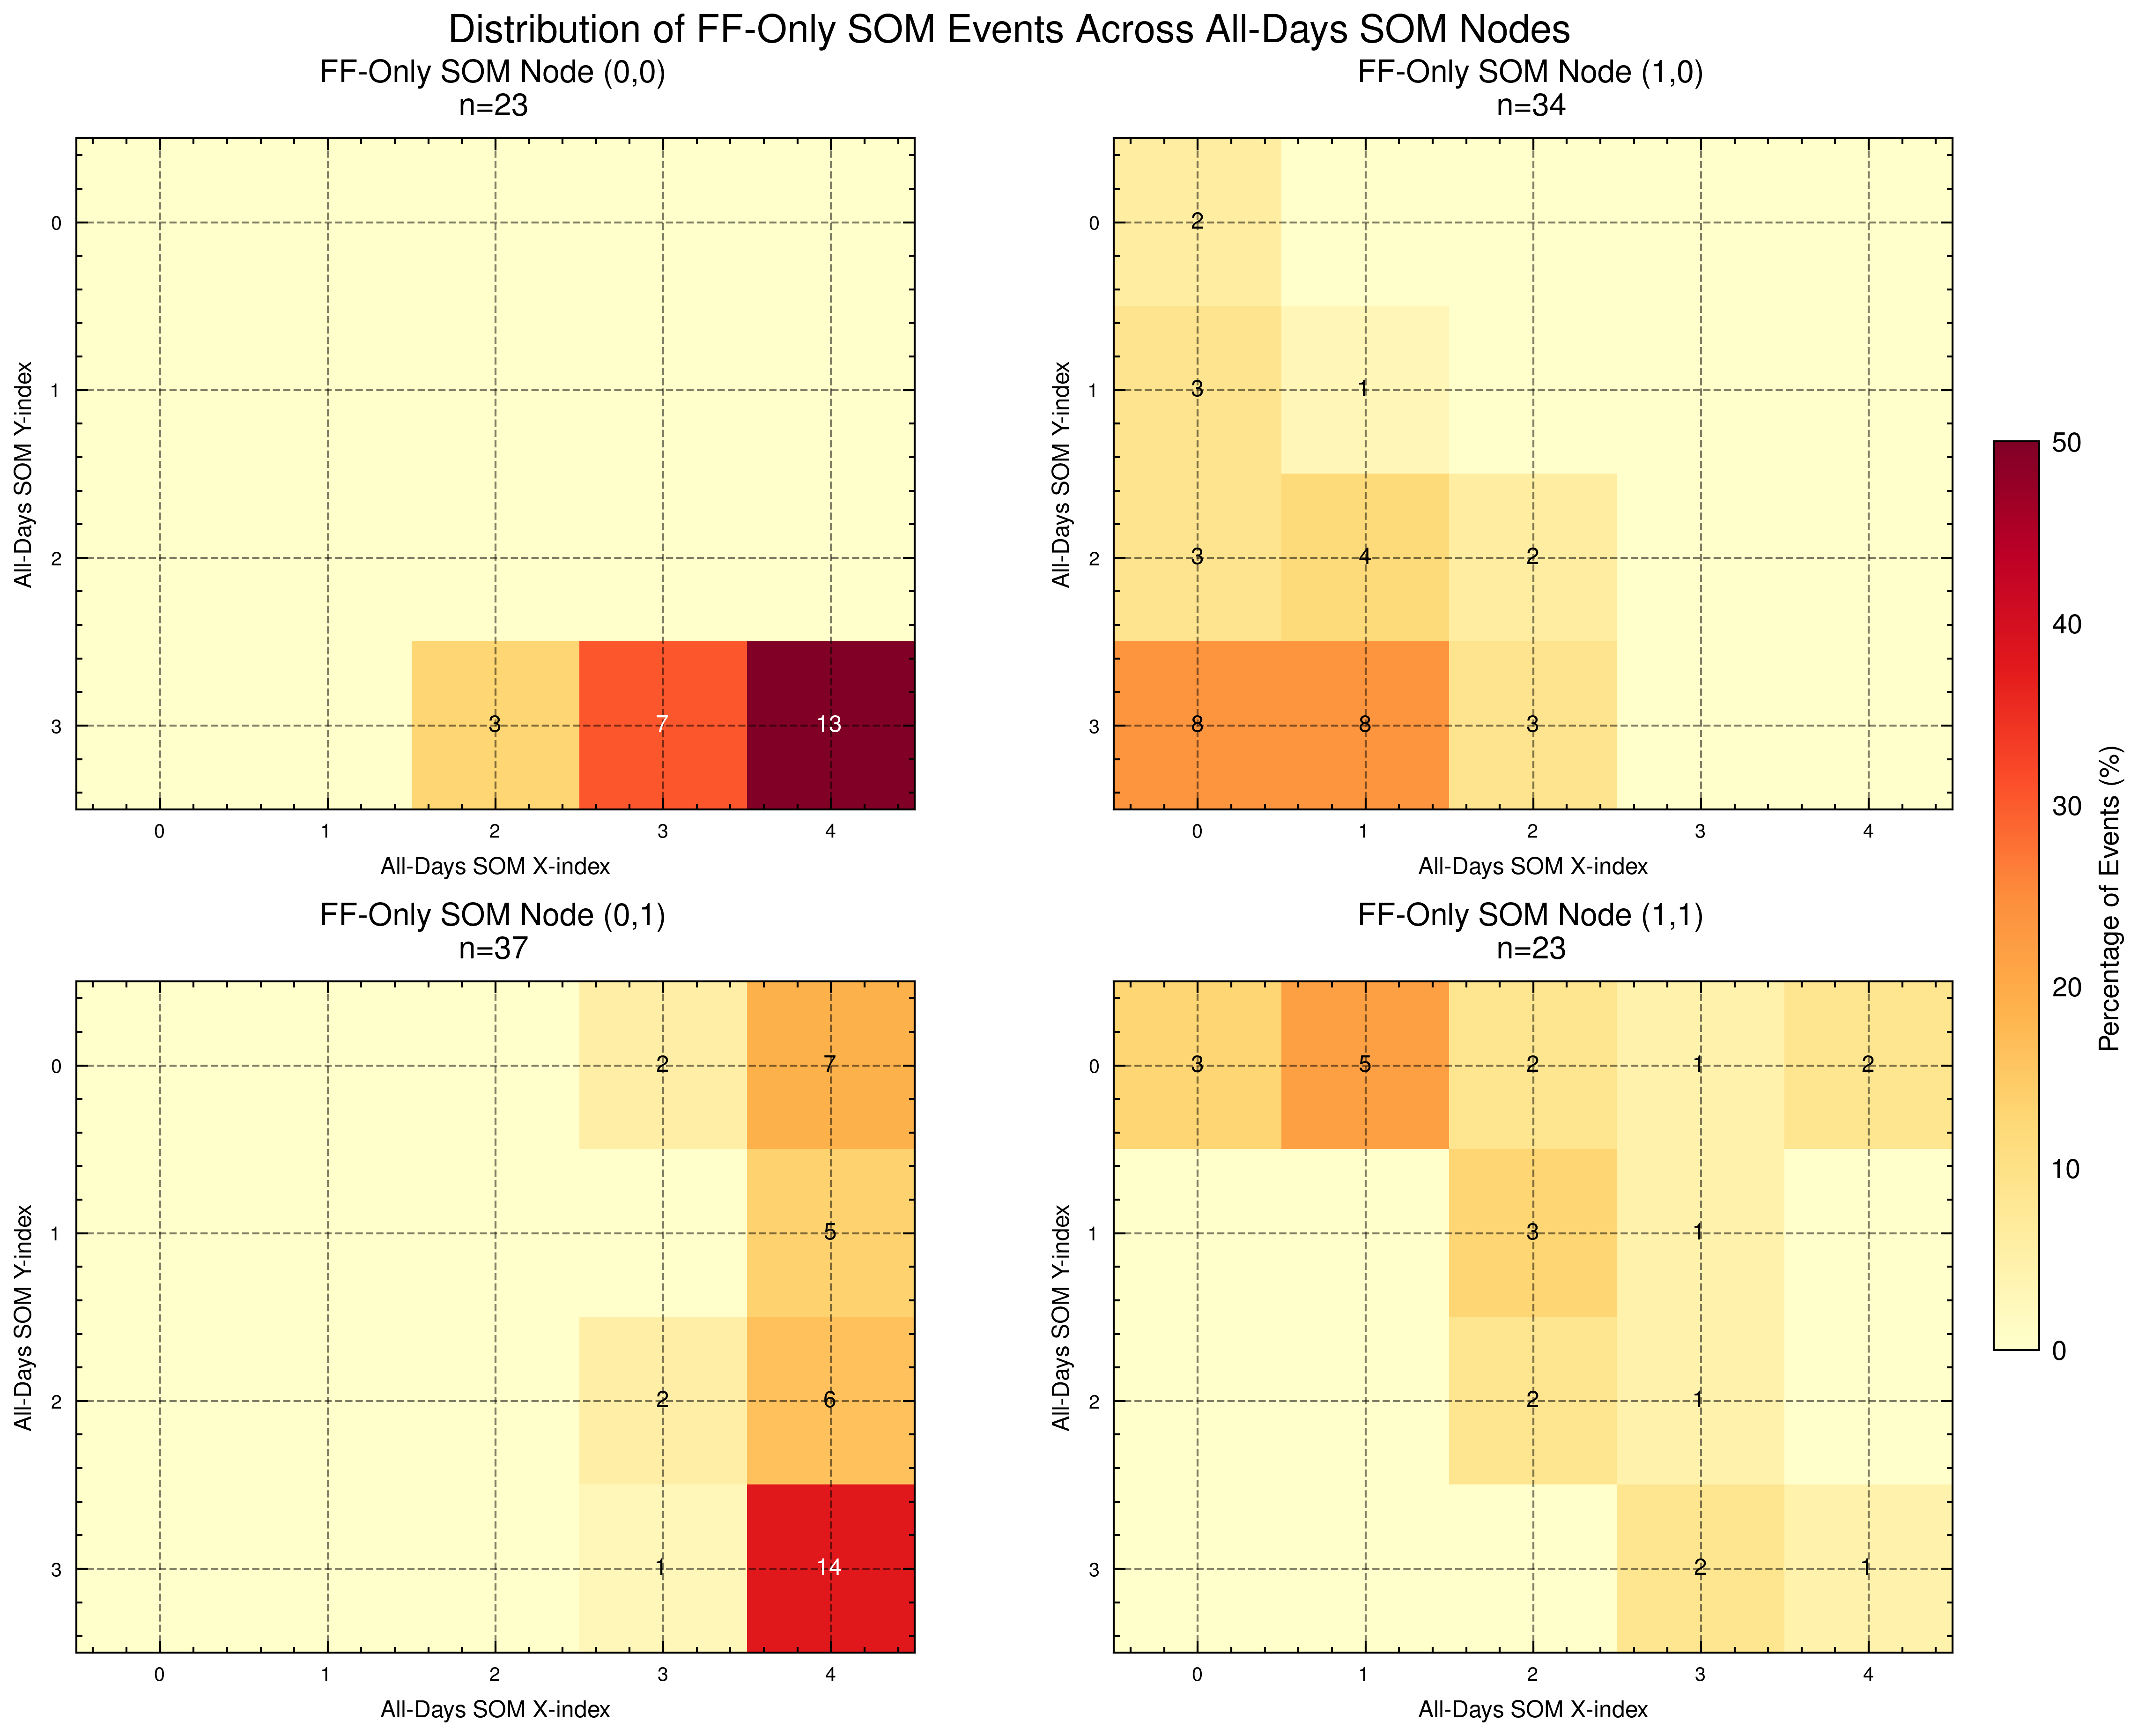

In [33]:
# Create a 2D mapping array: for each 2x2 node, show distribution across 5x4 grid
xdim_small, ydim_small = 2, 2
xdim_big, ydim_big = 5, 4

# Create figure with subplots for each 2x2 node
fig, axes = plt.subplots(
    ydim_small, xdim_small, figsize=(8, 6), dpi=600, layout="constrained"
)

for i in range(xdim_small):
    for j in range(ydim_small):
        ax = axes[j, i]
        node_2x2 = f"({i},{j})"

        # Get events for this 2x2 node
        subset = merged[merged["node_2x2"] == node_2x2]
        n_events = len(subset)

        # Create 5x4 count matrix
        counts = np.zeros((xdim_big, ydim_big))
        for _, row in subset.iterrows():
            bi, bj = int(row["node_5x4_i"]), int(row["node_5x4_j"])
            counts[bi, bj] += 1

        # Normalize to percentages
        if n_events > 0:
            pcts = 100 * counts / n_events
        else:
            pcts = counts

        # Plot heatmap
        im = ax.imshow(pcts.T, cmap="YlOrRd", origin="lower", vmin=0, vmax=50)

        # Add text annotations
        for bi in range(xdim_big):
            for bj in range(ydim_big):
                count = int(counts[bi, bj])
                if count > 0:
                    text_color = "white" if pcts[bi, bj] > 25 else "black"
                    ax.text(
                        bi,
                        bj,
                        str(count),
                        ha="center",
                        va="center",
                        fontsize=6,
                        color=text_color,
                    )

        ax.set_title(f"FF-Only SOM Node {node_2x2}\nn={n_events}", fontsize=8)
        ax.set_xlabel("All-Days SOM X-index", fontsize=6)
        ax.set_ylabel("All-Days SOM Y-index", fontsize=6)
        ax.set_xticks(np.arange(xdim_big))
        ax.set_yticks(np.arange(ydim_big))
        ax.tick_params(labelsize=5)
        ax.invert_yaxis()

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
cbar.set_label(r"Percentage of Events (\%)", fontsize=7)

plt.suptitle(
    "Distribution of FF-Only SOM Events Across All-Days SOM Nodes", fontsize=10, y=1.02
)
# plt.tight_layout()
plt.savefig("figs/som_2x2_to_5x4_heatmaps.png", bbox_inches="tight", dpi=300)
plt.show()


## Visualization: Sankey-style Flow Diagram

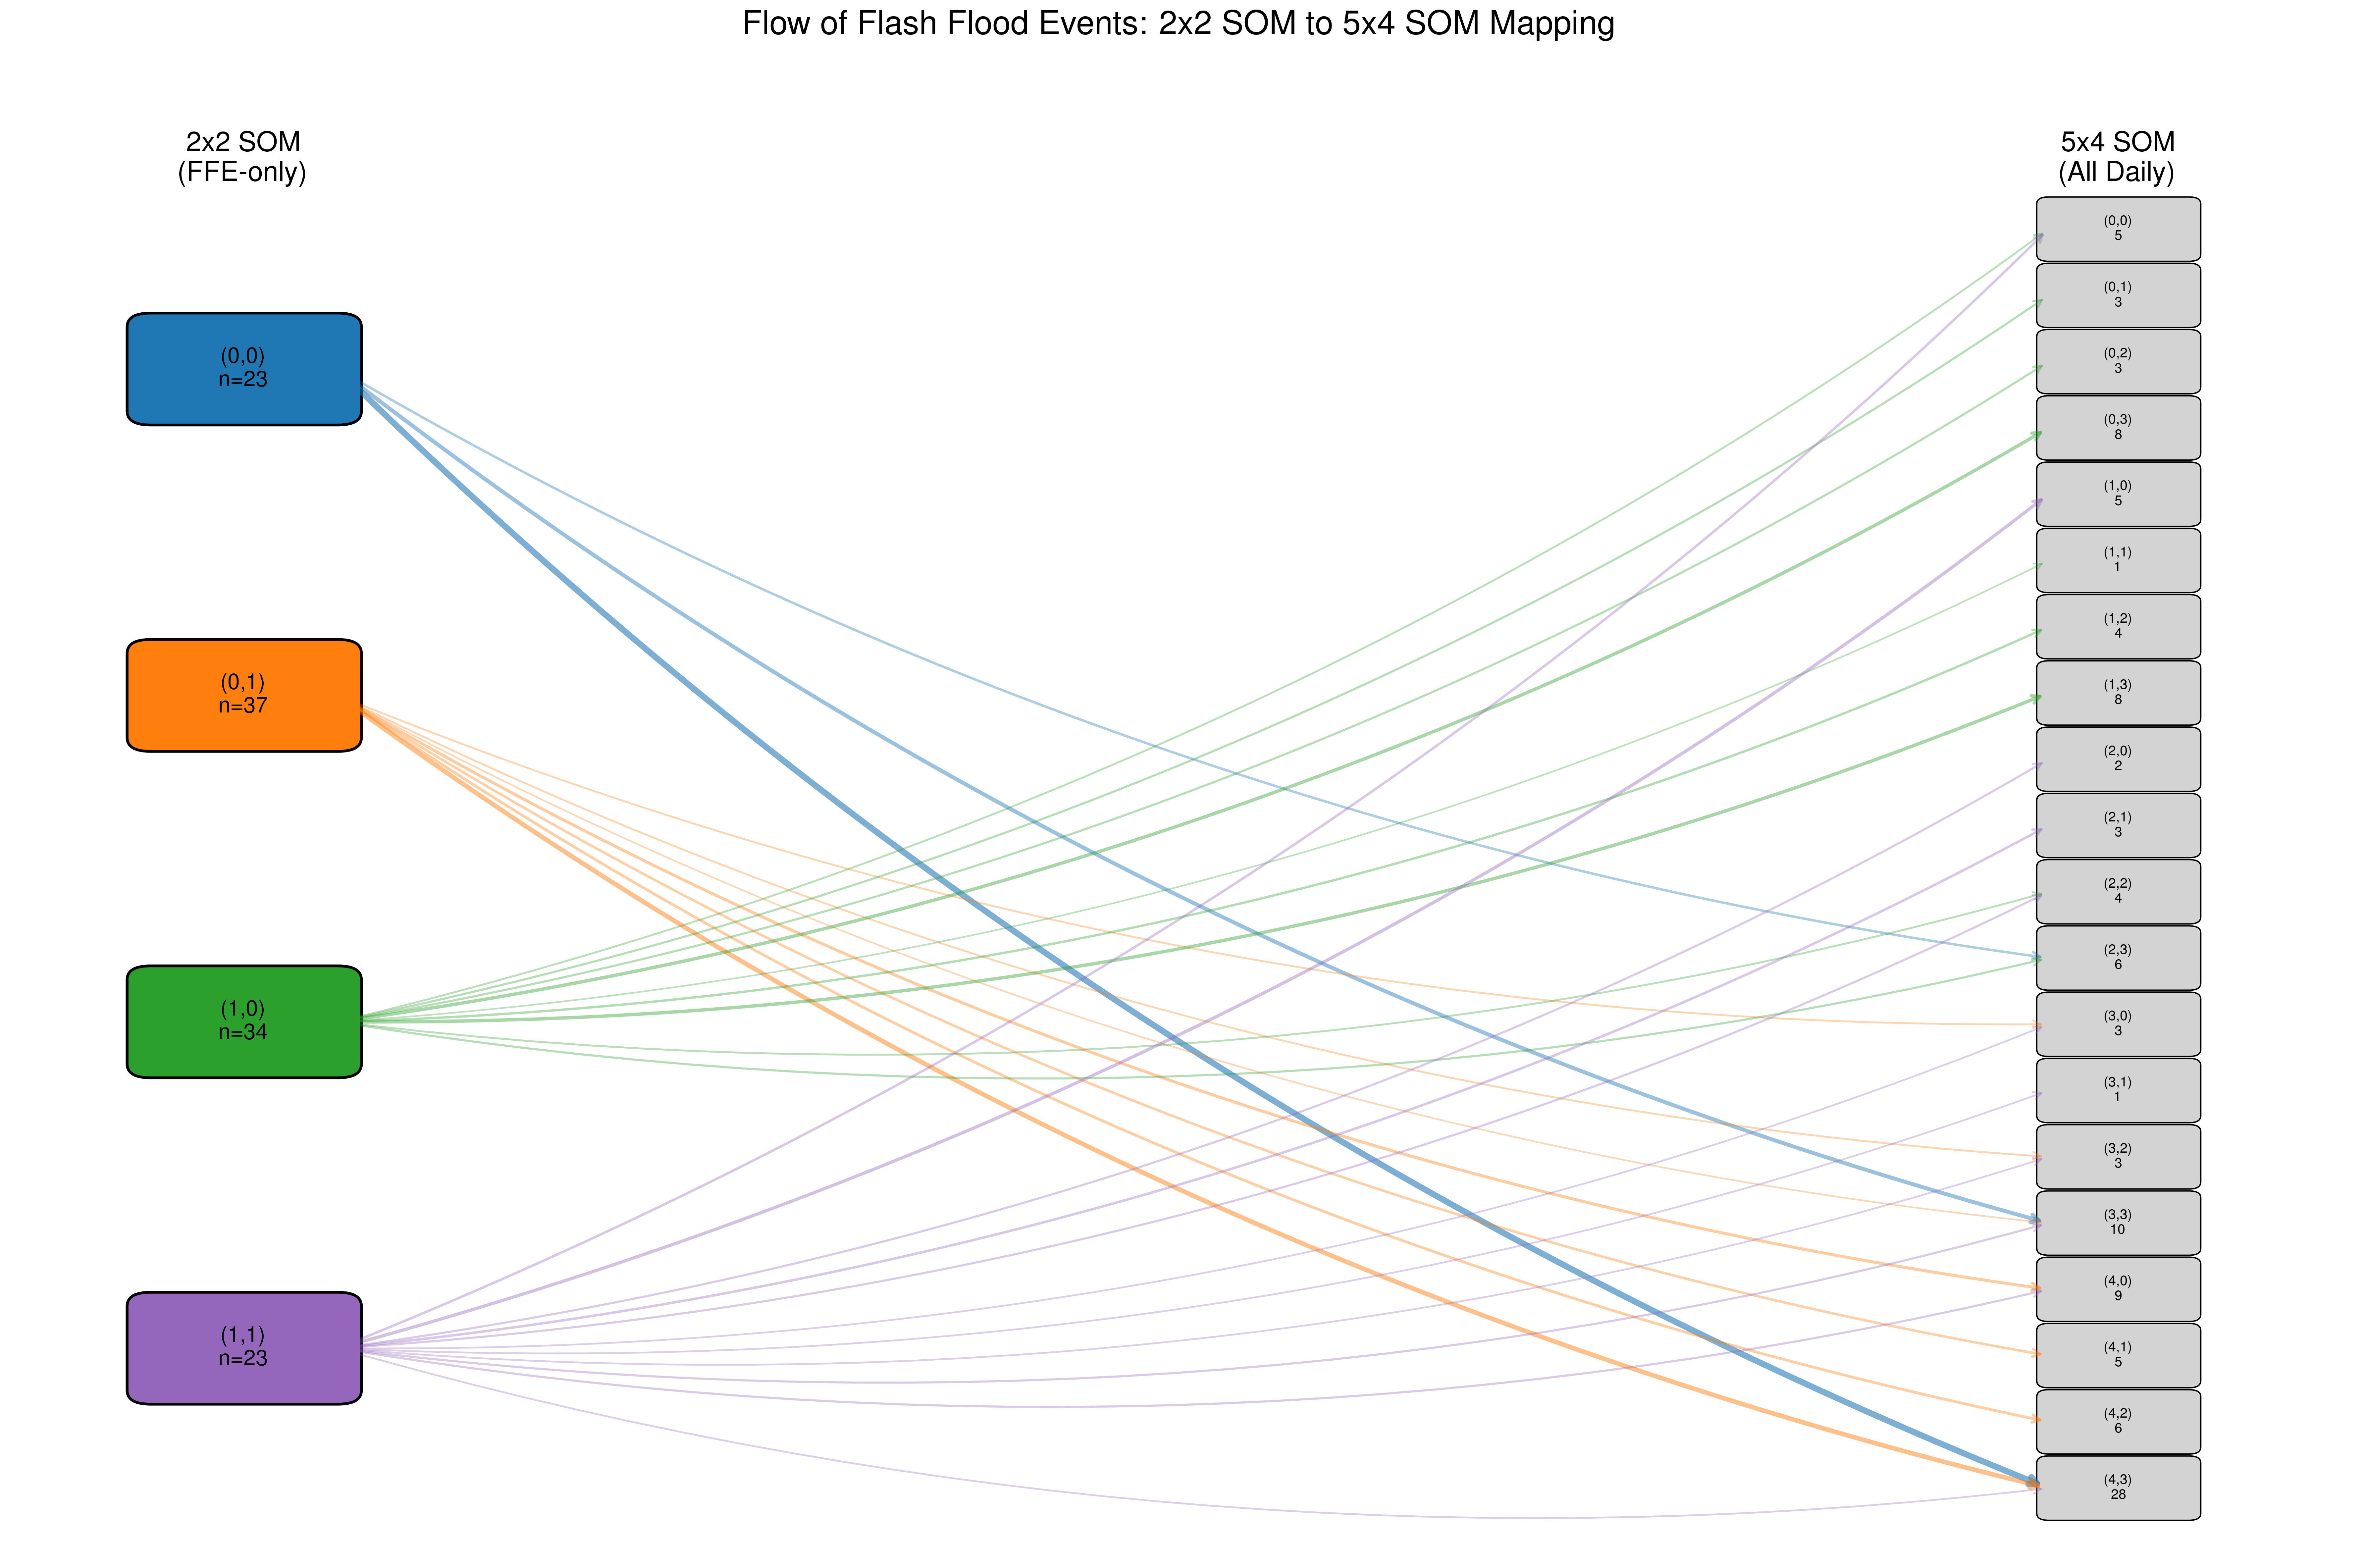

In [19]:
# Create a Sankey-style visualization using matplotlib
fig, ax = plt.subplots(figsize=(12, 8), dpi=600)

# Define positions for 2x2 nodes (left side) and 5x4 nodes (right side)
left_x = 0.1
right_x = 0.9

# 2x2 node positions (vertical arrangement)
n_small = xdim_small * ydim_small
small_y_positions = np.linspace(0.85, 0.15, n_small)
small_nodes = [(i, j) for i in range(xdim_small) for j in range(ydim_small)]

# 5x4 node positions (vertical arrangement)
n_big = xdim_big * ydim_big
big_y_positions = np.linspace(0.95, 0.05, n_big)
big_nodes = [(i, j) for i in range(xdim_big) for j in range(ydim_big)]

# Colors for 2x2 nodes
colors_2x2 = plt.cm.tab10(np.linspace(0, 0.4, n_small))

# Draw 2x2 nodes
small_node_centers = {}
for idx, (i, j) in enumerate(small_nodes):
    y = small_y_positions[idx]
    small_node_centers[(i, j)] = (left_x, y)

    # Count events for this node
    node_label = f"({i},{j})"
    n_events = len(merged[merged["node_2x2"] == node_label])

    # Draw box
    box = FancyBboxPatch(
        (left_x - 0.04, y - 0.03),
        0.08,
        0.06,
        boxstyle="round,pad=0.01",
        facecolor=colors_2x2[idx],
        edgecolor="black",
        linewidth=1,
    )
    ax.add_patch(box)
    ax.text(
        left_x,
        y,
        f"{node_label}\nn={n_events}",
        ha="center",
        va="center",
        fontsize=8,
        fontweight="bold",
    )

# Draw 5x4 nodes
big_node_centers = {}
for idx, (i, j) in enumerate(big_nodes):
    y = big_y_positions[idx]
    big_node_centers[(i, j)] = (right_x, y)

    # Count events for this node
    node_label = f"({i},{j})"
    n_events = len(merged[merged["node_5x4"] == node_label])

    # Draw box
    box = FancyBboxPatch(
        (right_x - 0.03, y - 0.018),
        0.06,
        0.036,
        boxstyle="round,pad=0.005",
        facecolor="lightgray",
        edgecolor="black",
        linewidth=0.5,
    )
    ax.add_patch(box)
    ax.text(
        right_x, y, f"{node_label}\n{n_events}", ha="center", va="center", fontsize=5
    )

# Draw flows (connections)
for idx, (si, sj) in enumerate(small_nodes):
    small_label = f"({si},{sj})"
    subset = merged[merged["node_2x2"] == small_label]
    n_total = len(subset)

    if n_total == 0:
        continue

    # Get distribution to big nodes
    for bi, bj in big_nodes:
        big_label = f"({bi},{bj})"
        n_flow = len(subset[subset["node_5x4"] == big_label])

        if n_flow == 0:
            continue

        # Calculate line width based on flow
        width = 0.5 + 3 * (n_flow / n_total)
        alpha = 0.3 + 0.5 * (n_flow / n_total)

        # Get positions
        x1, y1 = small_node_centers[(si, sj)]
        x2, y2 = big_node_centers[(bi, bj)]

        # Draw curved connection
        color = to_rgba(colors_2x2[idx], alpha)
        ax.annotate(
            "",
            xy=(x2 - 0.03, y2),
            xytext=(x1 + 0.04, y1),
            arrowprops=dict(
                arrowstyle="->",
                connectionstyle="arc3,rad=0.1",
                color=color,
                linewidth=width,
            ),
        )

# Labels
ax.text(
    left_x,
    0.98,
    "2x2 SOM\n(FFE-only)",
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold",
)
ax.text(
    right_x,
    0.98,
    "5x4 SOM\n(All Daily)",
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold",
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.axis("off")
ax.set_title(
    "Flow of Flash Flood Events: 2x2 SOM to 5x4 SOM Mapping", fontsize=12, pad=20
)

plt.tight_layout()
plt.savefig("figs/som_2x2_to_5x4_flow.png", bbox_inches="tight", dpi=300)
plt.show()


## Visualization: Combined 5x4 Grid with 2x2 Node Coloring

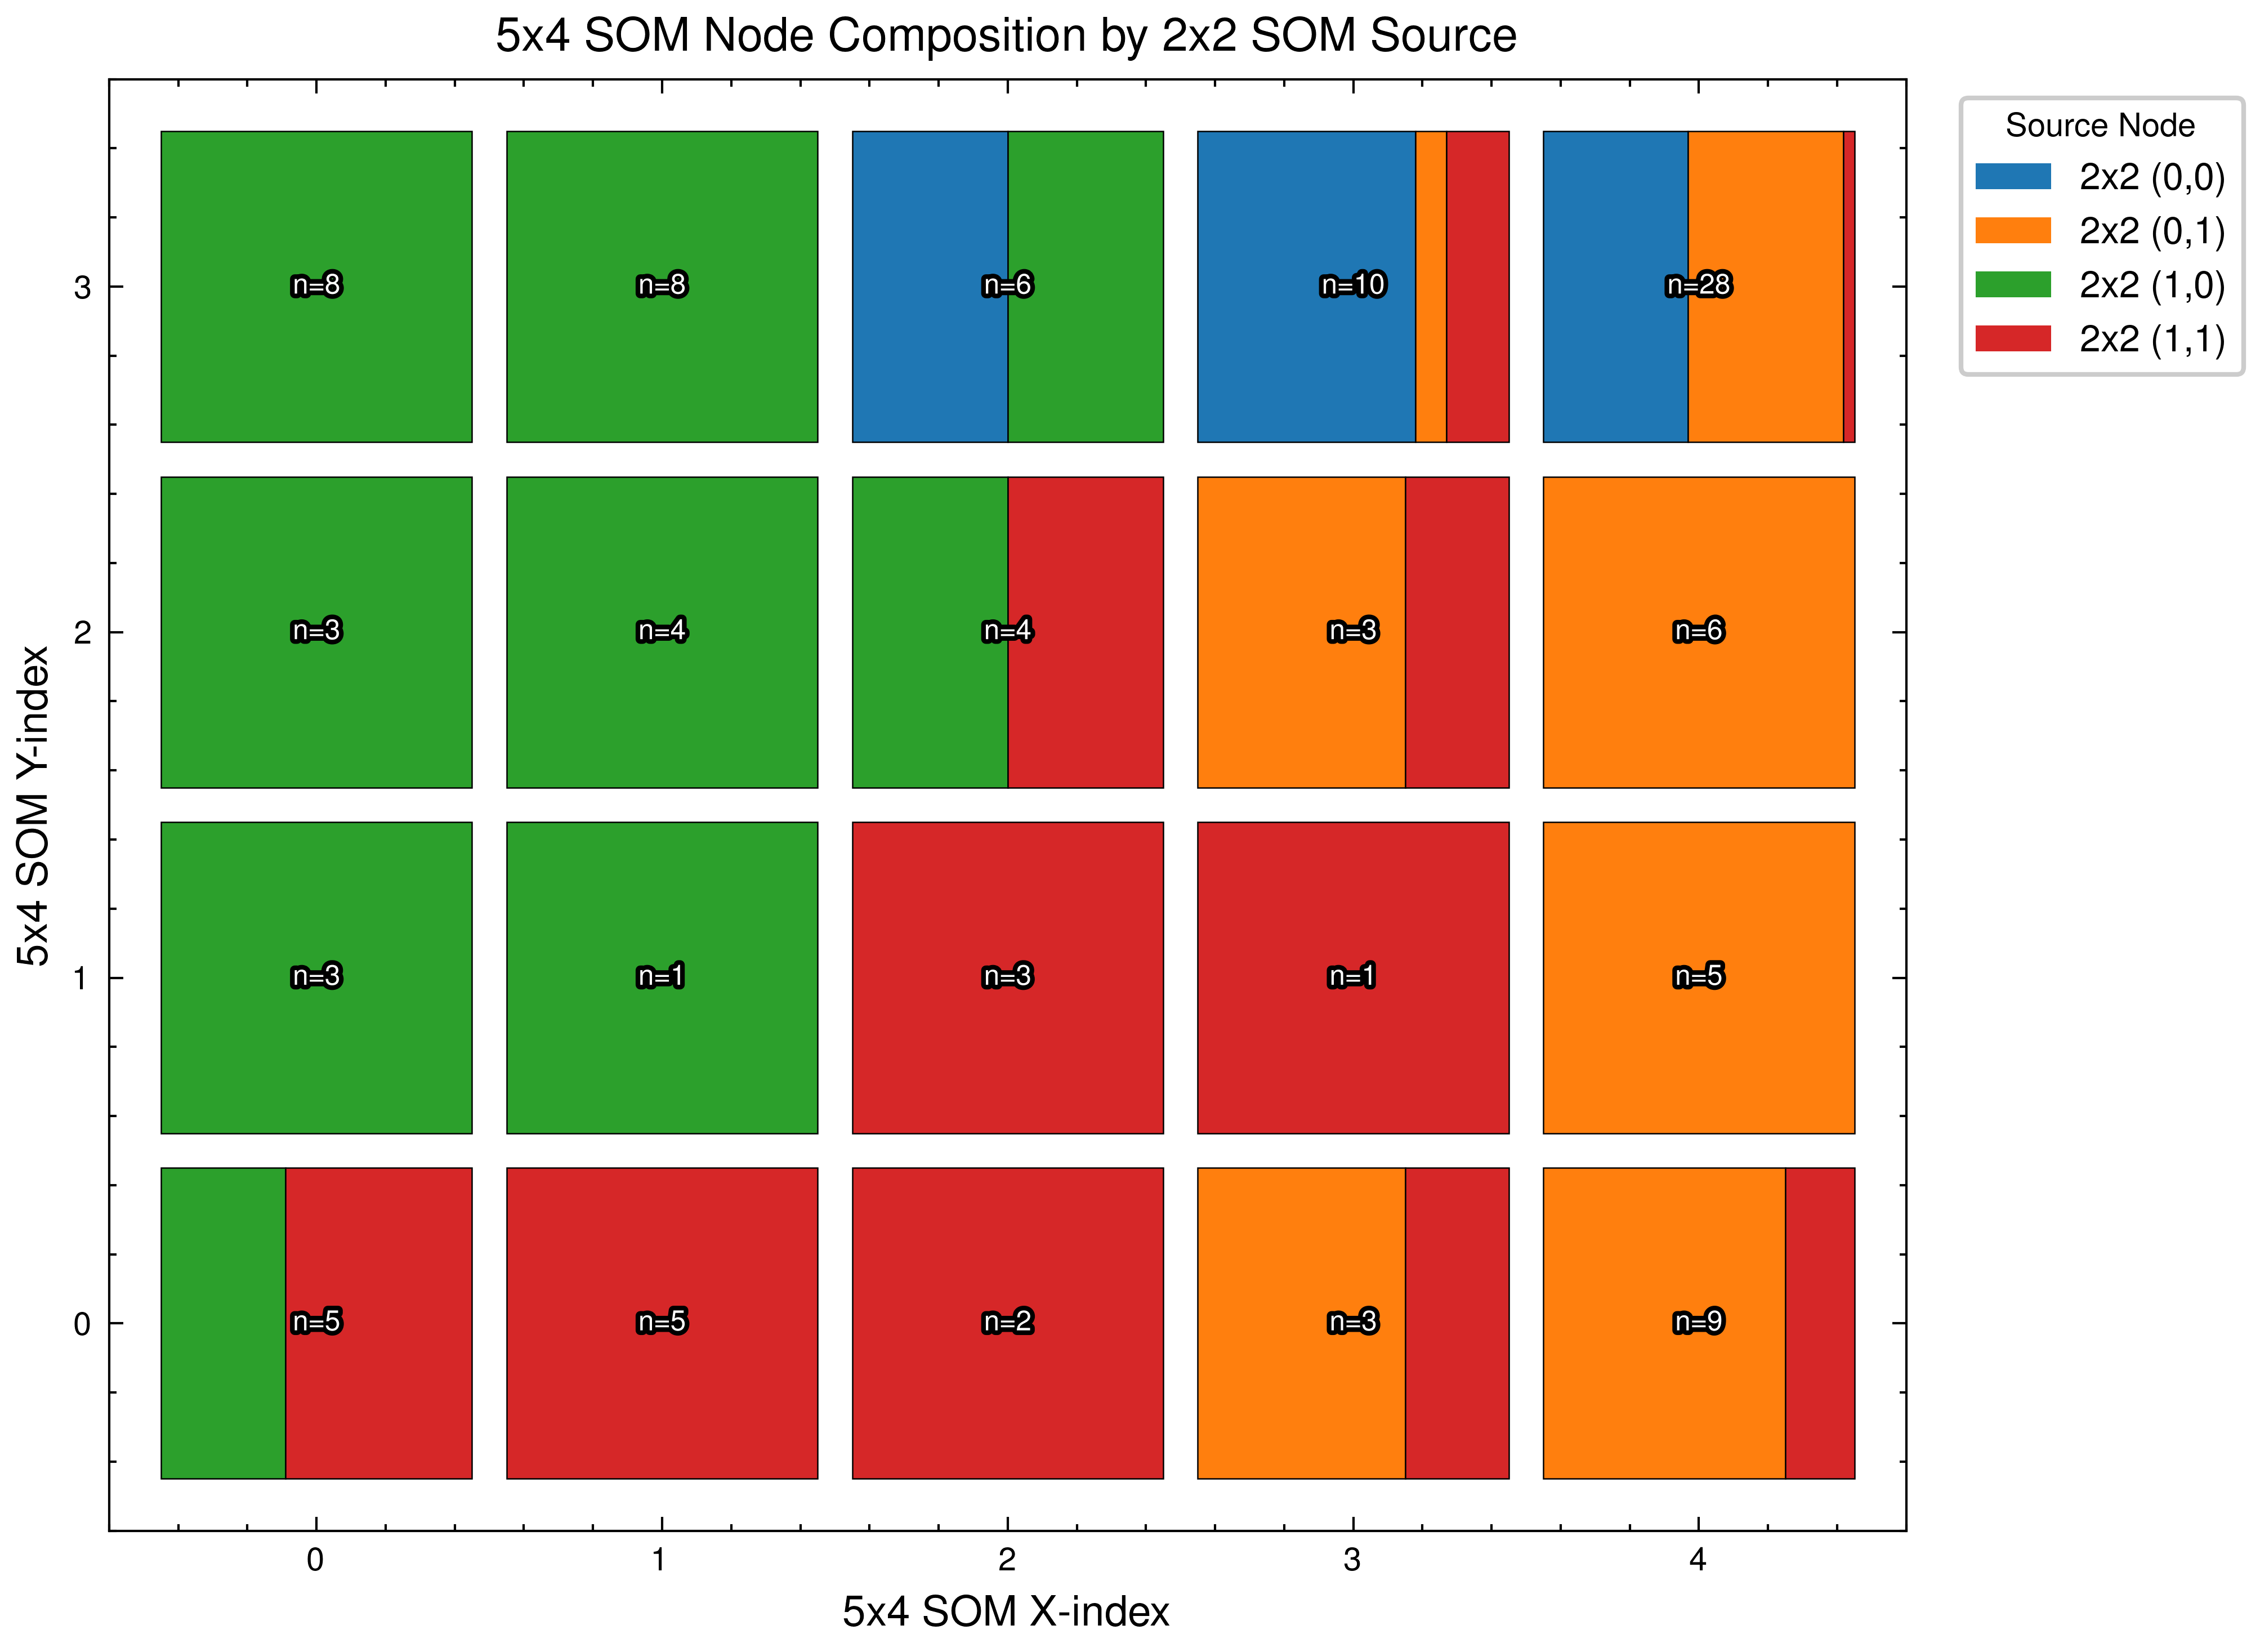

In [25]:
# Create a single 5x4 grid showing the dominant 2x2 source for each node
fig, ax = plt.subplots(figsize=(7, 5), dpi=600)

# Colors for 2x2 nodes
color_map = {
    "(0,0)": "#1f77b4",  # blue
    "(0,1)": "#ff7f0e",  # orange
    "(1,0)": "#2ca02c",  # green
    "(1,1)": "#d62728",  # red
}

# Create grid showing composition of each 5x4 node
for i in range(xdim_big):
    for j in range(ydim_big):
        node_5x4 = f"({i},{j})"
        subset = merged[merged["node_5x4"] == node_5x4]
        n_total = len(subset)

        if n_total == 0:
            # Draw empty cell
            rect = plt.Rectangle(
                (i - 0.45, j - 0.45),
                0.9,
                0.9,
                facecolor="lightgray",
                edgecolor="black",
                linewidth=0.5,
            )
            ax.add_patch(rect)
            ax.text(i, j, "n=0", ha="center", va="center", fontsize=6)
            continue

        # Calculate fractions from each 2x2 node
        fractions = {}
        for node_2x2 in color_map.keys():
            count = len(subset[subset["node_2x2"] == node_2x2])
            if count > 0:
                fractions[node_2x2] = count / n_total

        # Draw stacked bar (horizontal)
        x_start = i - 0.45
        bar_width = 0.9
        bar_height = 0.9

        cumulative = 0
        for node_2x2, frac in sorted(fractions.items()):
            width = bar_width * frac
            rect = plt.Rectangle(
                (x_start + cumulative * bar_width, j - 0.45),
                width,
                bar_height,
                facecolor=color_map[node_2x2],
                edgecolor="black",
                linewidth=0.3,
            )
            ax.add_patch(rect)
            cumulative += frac

        # Add count label
        ax.text(
            i,
            j,
            f"n={n_total}",
            ha="center",
            va="center",
            fontsize=6,
            fontweight="bold",
            color="white",
            path_effects=[
                patheffects.withStroke(linewidth=2, foreground="black")
            ],
        )

# Add legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color, label=f"2x2 {node}")
    for node, color in color_map.items()
]
ax.legend(
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    fontsize=8,
    title="Source Node",
)

ax.set_xlim(-0.6, xdim_big - 0.4)
ax.set_ylim(-0.6, ydim_big - 0.4)
ax.set_xticks(np.arange(xdim_big))
ax.set_yticks(np.arange(ydim_big))
ax.set_xlabel("5x4 SOM X-index", fontsize=9)
ax.set_ylabel("5x4 SOM Y-index", fontsize=9)
ax.set_title("5x4 SOM Node Composition by 2x2 SOM Source", fontsize=10)
ax.set_aspect("equal")
ax.grid(False)

plt.tight_layout()
plt.savefig("figs/som_5x4_composition_by_2x2.png", bbox_inches="tight", dpi=300)
plt.show()


## Summary Statistics

In [26]:
# Calculate entropy/spread for each 2x2 node
from scipy.stats import entropy

print("Dispersion of 2x2 SOM Events Across 5x4 SOM:")
print("=" * 60)

for node_2x2 in sorted(merged["node_2x2"].unique()):
    subset = merged[merged["node_2x2"] == node_2x2]
    n_events = len(subset)
    
    # Count distribution across 5x4 nodes
    counts = subset.groupby("node_5x4").size()
    probs = counts / counts.sum()
    
    # Calculate entropy (higher = more spread out)
    ent = entropy(probs)
    
    # Number of 5x4 nodes used
    n_nodes_used = len(counts)
    
    # Top destination
    top_node = counts.idxmax()
    top_pct = 100 * counts.max() / n_events
    
    print(f"\n2x2 Node {node_2x2}:")
    print(f"  Events: {n_events}")
    print(f"  Spread across {n_nodes_used} of 20 possible 5x4 nodes")
    print(f"  Entropy: {ent:.2f} (max possible: {np.log(20):.2f})")
    print(f"  Top destination: 5x4 {top_node} ({top_pct:.1f}%)")

Dispersion of 2x2 SOM Events Across 5x4 SOM:

2x2 Node (0,0):
  Events: 23
  Spread across 3 of 20 possible 5x4 nodes
  Entropy: 0.95 (max possible: 3.00)
  Top destination: 5x4 (4,3) (56.5%)

2x2 Node (0,1):
  Events: 37
  Spread across 7 of 20 possible 5x4 nodes
  Entropy: 1.66 (max possible: 3.00)
  Top destination: 5x4 (4,3) (37.8%)

2x2 Node (1,0):
  Events: 34
  Spread across 9 of 20 possible 5x4 nodes
  Entropy: 2.01 (max possible: 3.00)
  Top destination: 5x4 (0,3) (23.5%)

2x2 Node (1,1):
  Events: 23
  Spread across 11 of 20 possible 5x4 nodes
  Entropy: 2.26 (max possible: 3.00)
  Top destination: 5x4 (1,0) (21.7%)


In [27]:
# Reverse analysis: for each 5x4 node, what % comes from each 2x2 node?
print("\nComposition of 5x4 SOM Nodes by 2x2 Source:")
print("=" * 60)

for bi in range(xdim_big):
    for bj in range(ydim_big):
        node_5x4 = f"({bi},{bj})"
        subset = merged[merged["node_5x4"] == node_5x4]
        n_events = len(subset)
        
        if n_events == 0:
            continue
        
        # Count from each 2x2 node
        composition = subset.groupby("node_2x2").size()
        
        comp_str = ", ".join([f"{node}: {count} ({100*count/n_events:.0f}%)" 
                              for node, count in composition.items()])
        print(f"5x4 {node_5x4} (n={n_events}): {comp_str}")


Composition of 5x4 SOM Nodes by 2x2 Source:
5x4 (0,0) (n=5): (1,0): 2 (40%), (1,1): 3 (60%)
5x4 (0,1) (n=3): (1,0): 3 (100%)
5x4 (0,2) (n=3): (1,0): 3 (100%)
5x4 (0,3) (n=8): (1,0): 8 (100%)
5x4 (1,0) (n=5): (1,1): 5 (100%)
5x4 (1,1) (n=1): (1,0): 1 (100%)
5x4 (1,2) (n=4): (1,0): 4 (100%)
5x4 (1,3) (n=8): (1,0): 8 (100%)
5x4 (2,0) (n=2): (1,1): 2 (100%)
5x4 (2,1) (n=3): (1,1): 3 (100%)
5x4 (2,2) (n=4): (1,0): 2 (50%), (1,1): 2 (50%)
5x4 (2,3) (n=6): (0,0): 3 (50%), (1,0): 3 (50%)
5x4 (3,0) (n=3): (0,1): 2 (67%), (1,1): 1 (33%)
5x4 (3,1) (n=1): (1,1): 1 (100%)
5x4 (3,2) (n=3): (0,1): 2 (67%), (1,1): 1 (33%)
5x4 (3,3) (n=10): (0,0): 7 (70%), (0,1): 1 (10%), (1,1): 2 (20%)
5x4 (4,0) (n=9): (0,1): 7 (78%), (1,1): 2 (22%)
5x4 (4,1) (n=5): (0,1): 5 (100%)
5x4 (4,2) (n=6): (0,1): 6 (100%)
5x4 (4,3) (n=28): (0,0): 13 (46%), (0,1): 14 (50%), (1,1): 1 (4%)
